In [ ]:
import torch
from torch import nn
from torch import optim, cuda
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [ ]:
# the dataset; consists only of times in an interval [a, b]

class Data(Dataset):
  def __init__(self, t):
    self.t = torch.from_numpy(t.astype(np.float32))
    self.length = np.shape(t)[0]

  def __getitem__(self, index):
    return self.t[index]

  def __len__(self):
    return self.length

In [ ]:
class SineLayer(nn.Module):
    # This class definition is borrowed from the paper Implicit Neural Representations with Periodic Activation Functions by
    # Sitzmann, Vincent et al. (2020)

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, activ=torch.sin):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()
        self.activ = activ

    def init_weights(self):
        with torch.no_grad():
            self.linear.bias.uniform_(-3.14 ,3.14)
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return self.activ(self.omega_0 * self.linear(input))

In [ ]:
    # This class definition is a modification from the one provided in the paper Implicit Neural Representations with Periodic Activation Functions by
    # Sitzmann, Vincent et al. (2020)

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=2., activ=torch.sin):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0, activ=activ))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0, activ=activ))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0, activ=activ))

        self.net = nn.Sequential(*self.net)
        self.params = dict(self.net.named_parameters())

    def compute_output(self, inputs):
      outputs = torch.func.functional_call(self.net, self.params, inputs)
      return outputs, outputs

# gradients is the derivative of the output of the network w.r.t. input t
    def compute_grad(self, inputs):
      gradients, values = torch.func.jacrev(self.compute_output, has_aux=True)(inputs)
      gradients = torch.squeeze(gradients, -1)
      return gradients, values

# gradients is the derivative of the output of the network w.r.t. input t. s_gradients is the
# double derivative of the output of the network w.r.t. input t
    def compute_jac(self, inputs):
      s_gradients, values = torch.func.jacrev(self.compute_grad, has_aux=True)(inputs)
      gradients, values = self.compute_grad(inputs)
      s_gradients = torch.squeeze(s_gradients, -1)
      return s_gradients, gradients, values

    def forward(self, t):
        s_gradients, gradients, outputs = torch.vmap(self.compute_jac, in_dims=(0))(t)
        return t, outputs, gradients, s_gradients

In [ ]:
# The RHS of our ODE (in the ODEs we considered, this is x'(t)=f(x(t),t) or x''(t)=f(x(t),t));
# function definition can be modified to also take higher-order derivative as input as well
def func(x, t):
  y = -x
  return y

In [ ]:
# the true solution to the ODE
def solution_to_ODE(t):
  t = np.array(t)
  # -np.cos(t) + 2 + (np.cos(1) - 2) / np.sin(1) * np.sin(t)
  return np.cos(t) - np.cos(1) / np.sin(1) * np.sin(t)

In [ ]:
random_seed = 45
torch.manual_seed(random_seed)

In [ ]:
# Training and validation sets

t = np.arange(-2, 2, 0.001)

dataset = Data(t.reshape(-1, 1))

val_pct = 0.1
val_size = int(len(t) * val_pct)
train_size = len(t) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(len(train_ds), len(val_ds))

batch_size = 200

dataloaders = {
    'train': DataLoader(train_ds, batch_size = batch_size, shuffle=True),
    'val': DataLoader(val_ds, batch_size = batch_size, shuffle=True),
}

3600 400


In [ ]:
# Times to plot the graph at. Note this is equal to the t above

t = torch.arange(-2, 2, 0.001)

In [ ]:
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [ ]:
# training loop

def train(model, criteria, optimizer, train_loader, valid_loader, n_epochs):

  overall_start = timer()
  model.epochs = 0
  losses = []

  for epoch in range(n_epochs):
      train_loss = valid_loss = 0
      start = timer()
      for i, data in enumerate(train_loader):
        if train_on_gpu:
          data = data.cuda()
        optimizer.zero_grad()

        output = model(data)

        loss = criteria(output)
        loss.backward()

        optimizer.step()

        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        print(
              f'Epoch: {epoch}\t{100 * (i + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
              end='\r')
      else:
        model.epochs += 1
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            for data in valid_loader:
              # Tensors to gpu
              if train_on_gpu:
                  data = data.cuda()

              # Forward pass
              output = model(data)

              # Validation loss
              loss = criteria(output)
              # Multiply average loss times the number of examples in batch
              valid_loss += loss.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            losses.append(valid_loss)

            # Print training and validation results
            print(
                f'\nEpoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}'
            )
  # Attach the optimizer
  model.optimizer = optimizer
  # Record overall time and print out stats
  total_time = timer() - overall_start

  print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
)
  return model, losses

In [ ]:
# the loss function: x(t), x'(t) and x''(t) are calculated in terms of N(t) and its higher-order derivatives
def criteria(out):
  loss = nn.functional.mse_loss
  return loss(2*out[1] + (4*out[0]-2)*out[2]+(out[0]**2-out[0])*out[3], func(1-out[0] + out[0]*(out[0]-1)*out[1], out[0]))


In [ ]:
# this function returns the trial solution x(t) of the ODE
def evaluate(model, test_ds):
  test_ds = test_ds.cuda()
  out = model(test_ds)
  # test_ds.detach().cpu().numpy(), (1 + output[0].view(1, -1) * output[1][:, 0]).detach().cpu().numpy()
  return out[0].detach().cpu().numpy(), (1-out[0] + out[0]*(out[0]-1)*out[1]).detach().cpu().numpy()

In [ ]:
# plot the solution to the ODE
def plot_outputs(times, model_outputs, true_values):
  plt.scatter(times, model_outputs, label = 'model', s = 2)
  plt.scatter(times, true_values, label = 'true', s = 2)
  plt.xlabel('t')
  plt.ylabel('Function at time t')
  plt.title('Comparing learnt function with its true value')
  plt.legend(loc="upper left")
  plt.show()

In [ ]:
# Initializing and training the SIREN model with sine activations
model = Siren(in_features=1, out_features=1, hidden_features=10,
                  hidden_layers=10, outermost_linear=True, first_omega_0=1, hidden_omega_0=1)
if train_on_gpu:
    model = model.to('cuda')

optimizer = torch.optim.RAdam(model.parameters())

model, losses = train(model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 300)

Epoch: 0	100.00% complete. 0.54 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 5.504208664099376 	Validation Loss: 1.3884296417236328

Epoch: 1 	Training Loss: 1.2681674659252167 	Validation Loss: 1.1274652481079102
Epoch: 2	100.00% complete. 0.52 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.9832680424054464 	Validation Loss: 0.8714302480220795
Epoch: 3	100.00% complete. 0.55 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.761901792552736 	Validation Loss: 0.7037067711353302

Epoch: 4 	Training Loss: 0.6293765488598082 	Validation Loss: 0.5982451140880585
Epoch: 5	100.00% complete. 0.52 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.5418990204731623 	Validation Loss: 0.5224625468254089

Epoch: 6 	Training Loss: 0.47305895222557914 	Validation Loss: 0.45645642280578613
Epoch: 7	100.00% complete. 0.54 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.41014771660168964 	Validation Loss: 0.39162664115428925
Epoch: 8	100.00% complete. 0.53 seconds elapsed in epoch.

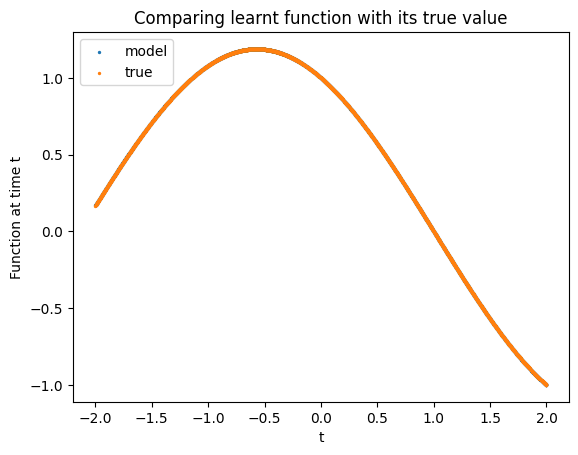

In [ ]:
# plotting the solution learnt from SIREN
t = t.view(-1, 1)
times, model_outputs = evaluate(model, t)

plot_outputs(times, model_outputs, solution_to_ODE(times))

In [ ]:
# Initializing and training a model with tanh activations. Note although the network is still name SIREN,
# the below model uses only tanh activations

tanh_model = Siren(in_features=1, out_features=1, hidden_features=10,
                  hidden_layers=10, outermost_linear=True, first_omega_0=1, hidden_omega_0=1,
              activ=torch.tanh)
if train_on_gpu:
    tanh_model = tanh_model.to('cuda')

optimizer = torch.optim.RAdam(tanh_model.parameters())
tanh_model, tanh_losses = train(tanh_model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 300)

Epoch: 0	100.00% complete. 0.73 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 4.123962998390198 	Validation Loss: 0.8065412044525146
Epoch: 1	100.00% complete. 0.52 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.7677188681231605 	Validation Loss: 0.8054371476173401

Epoch: 2 	Training Loss: 0.7644937766922845 	Validation Loss: 0.8049760162830353
Epoch: 3	100.00% complete. 0.49 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7619088755713569 	Validation Loss: 0.8050826191902161
Epoch: 4	100.00% complete. 0.50 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.759540554549959 	Validation Loss: 0.8056672513484955
Epoch: 5	100.00% complete. 0.50 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.757964379257626 	Validation Loss: 0.8065955340862274
Epoch: 6	100.00% complete. 0.50 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.7569340202543471 	Validation Loss: 0.807515025138855
Epoch: 7	100.00% complete. 0.50 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.756

In [ ]:
# Initializing and training a model with ReLU activations. Note although the network is still name SIREN,
# the below model uses only ReLU activations

relu_model = Siren(in_features=1, out_features=1, hidden_features=10,
                  hidden_layers=10, outermost_linear=True, first_omega_0=1, hidden_omega_0=1,
              activ=torch.nn.functional.relu)
if train_on_gpu:
    relu_model = relu_model.to('cuda')

optimizer = torch.optim.RAdam(relu_model.parameters())
relu_model, relu_losses = train(relu_model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 300)


Epoch: 0 	Training Loss: 90.50972938537598 	Validation Loss: 16.444154739379883
Epoch: 1	100.00% complete. 0.43 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 16.36341322792901 	Validation Loss: 16.137951374053955

Epoch: 2 	Training Loss: 15.975243091583252 	Validation Loss: 15.690890789031982
Epoch: 3	100.00% complete. 0.42 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 15.461063437991672 	Validation Loss: 15.12532663345337
Epoch: 4	100.00% complete. 0.43 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 14.837086041768393 	Validation Loss: 14.483208179473877
Epoch: 5	100.00% complete. 0.44 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 14.144078625573052 	Validation Loss: 13.774926662445068
Epoch: 6	100.00% complete. 0.55 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 13.398376093970406 	Validation Loss: 13.019699096679688

Epoch: 7 	Training Loss: 12.614822228749594 	Validation Loss: 12.240815162658691
Epoch: 8	100.00% complete. 0.55 seconds elapsed in epoch.
Epoc

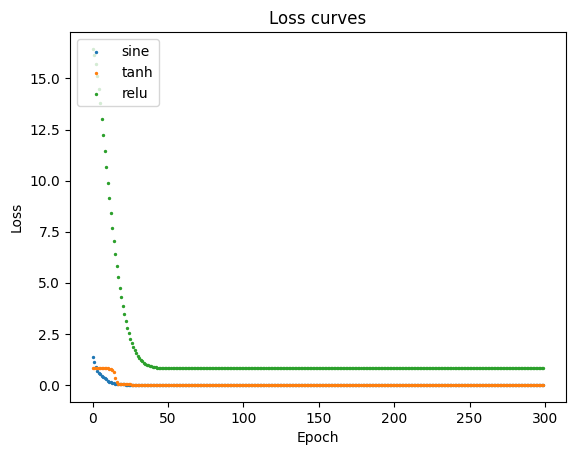

In [ ]:
# plot losses
EPOCHS = 300
plt.scatter(np.arange(EPOCHS), losses, label = 'sine', s = 2)
plt.scatter(np.arange(EPOCHS), tanh_losses, label = 'tanh', s = 2)
plt.scatter(np.arange(EPOCHS), relu_losses, label = 'relu', s = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.legend(loc="upper left")
plt.show()

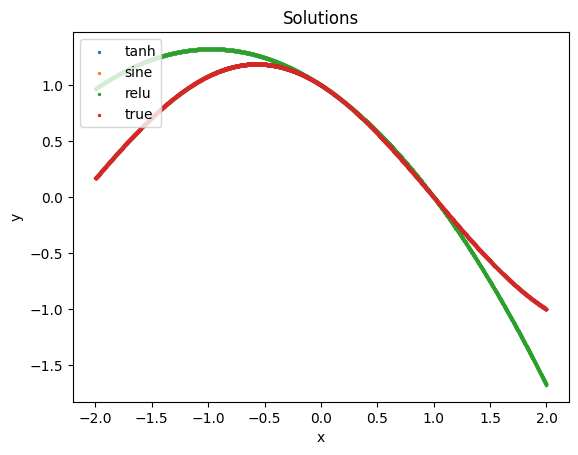

In [ ]:
# plot solutions to the ODE learnt from each model

times, sine_model_outputs = evaluate(model, t)
times, tanh_model_outputs = evaluate(tanh_model, t)
times, relu_model_outputs = evaluate(relu_model, t)

plt.scatter(times, tanh_model_outputs, label = 'tanh', s = 2)
plt.scatter(times, sine_model_outputs, label = 'sine', s = 2)
plt.scatter(times, relu_model_outputs, label = 'relu', s = 2)
plt.scatter(times, solution_to_ODE(times), label = 'true', s = 2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solutions')
plt.legend(loc="upper left")
plt.show()